# **Toxic Comment Classification using NLP**

*Importing libraries*

In [2]:
!pip install nlp_utils
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.3 MB/s 
     |████████████████████████████████| 287 kB 42.1 MB/s 


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
import string
import nlp_utils
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

*Importing Dataset*

In [4]:
dataset = pd.read_csv('/content/traindata.csv')
dataset

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


*Checking the null values*

In [6]:
dataset.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

*Counting threating sentence*

In [7]:
dataset['toxic'].value_counts() 

0    144277
1     15294
Name: toxic, dtype: int64

In [8]:
dataset['severe_toxic'].value_counts() 

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [9]:
dataset['obscene'].value_counts() 

0    151122
1      8449
Name: obscene, dtype: int64

In [10]:
dataset['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [11]:
dataset['insult'].value_counts() 

0    151694
1      7877
Name: insult, dtype: int64

In [12]:
dataset['identity_hate'].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

# ***Data Visualization***

In [13]:
#taking only numerical columns
num_col = dataset.iloc[:,2:].sum()
num_col

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

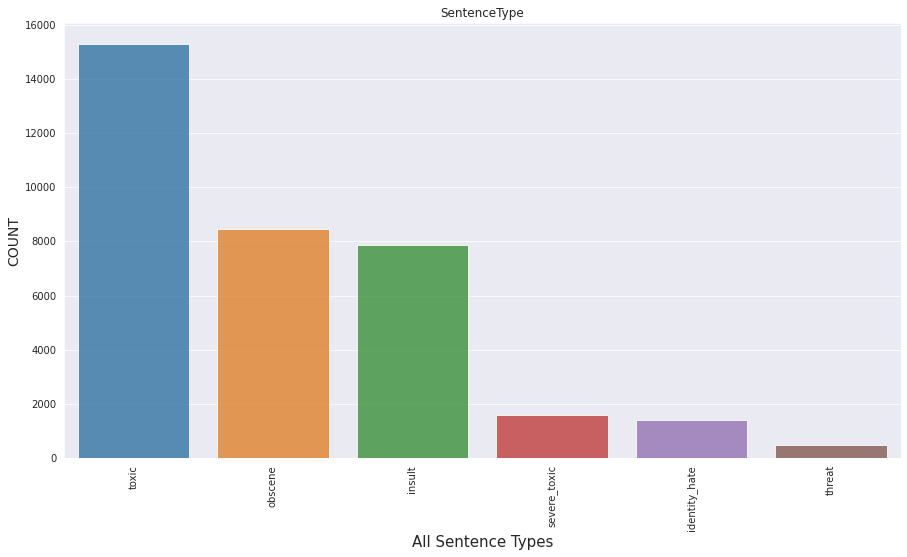

In [14]:
sns.set_style("darkgrid")
nc = num_col.sort_values(ascending=False)
plt.figure(figsize=(15,8))
temp =sns.barplot(nc.index, nc.values, alpha=0.8) 
plt.title('SentenceType')
plt.ylabel('COUNT', fontsize=14)
plt.xlabel('All Sentence Types', fontsize=15)
temp.set_xticklabels(rotation=90,labels=nc.index,fontsize=10)
plt.show()

# ***Pre-processing the data***

*Removing spacial characters from comments*

In [15]:
import re
import string
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
dataset['comment_text'] = dataset['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

*Creating different dataframe*

In [16]:
insulting_comment = dataset.loc[:,['id','comment_text','insult']]
hate_comment = dataset.loc[:,['id','comment_text','identity_hate']]
threatening_comment = dataset.loc[:,['id','comment_text','threat']]
obscene_comment = dataset.loc[:,['id','comment_text','obscene']]
severe_toxic_comment = dataset.loc[:,['id','comment_text','severe_toxic']]
toxic_comment = dataset.loc[:,['id','comment_text','toxic']]

# ***Visualizing subset datasets using wordcloud***

In [17]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
def wordcloud(dataset, label):
    
    subset=dataset[dataset[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=2000)
    wc.generate(" ".join(text))
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=15)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=0), alpha=0.98)

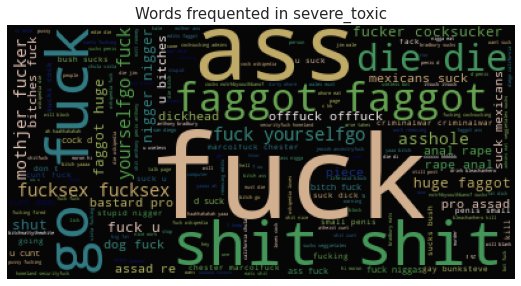

In [18]:
wordcloud(severe_toxic_comment,'severe_toxic')

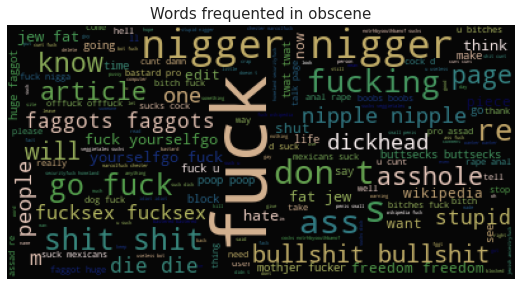

In [19]:
wordcloud(obscene_comment,'obscene')

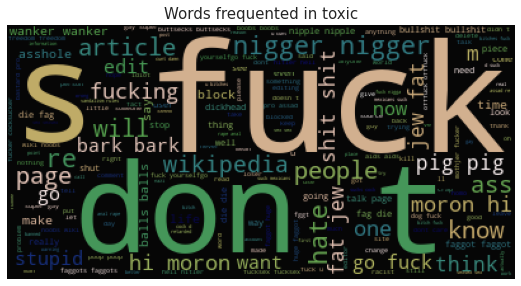

In [20]:
wordcloud(toxic_comment,'toxic')

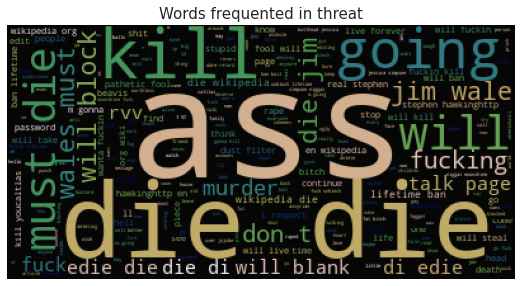

In [21]:
wordcloud(threatening_comment,'threat')

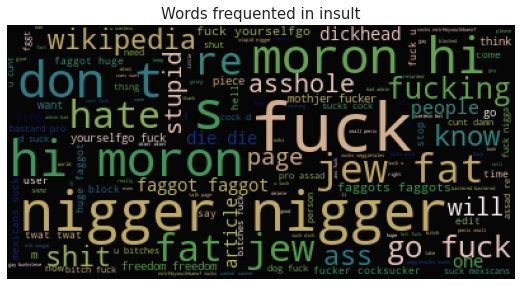

In [22]:
wordcloud(insulting_comment,'insult')

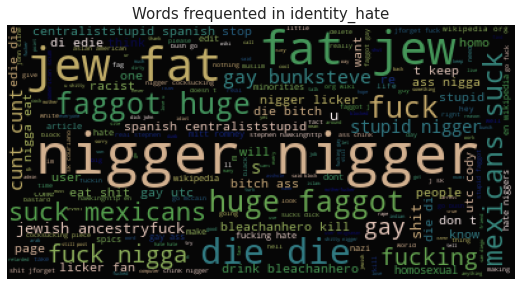

In [23]:
wordcloud(hate_comment,'identity_hate')

# ***Balancing the target column in the dataset***

In [35]:
toxic_comment['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [37]:
balanced_toxic_comment_1 = toxic_comment[toxic_comment['toxic'] == 1].iloc[0:15294,:]
balanced_toxic_comment_0 = toxic_comment[toxic_comment['toxic'] == 0].iloc[0:15294,:]
balanced_toxic_comment = pd.concat([balanced_toxic_comment_1, balanced_toxic_comment_0])
balanced_toxic_comment['toxic'].value_counts()

1    15294
0    15294
Name: toxic, dtype: int64

In [38]:
severe_toxic_comment['severe_toxic'].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [41]:
balanced_severe_toxic_comment_1 = severe_toxic_comment[severe_toxic_comment['severe_toxic'] == 1].iloc[0:1595,:]
balanced_severe_toxic_comment_0 = severe_toxic_comment[severe_toxic_comment['severe_toxic'] == 0].iloc[0:1595,:]
balanced_severe_toxic_comment = pd.concat([balanced_severe_toxic_comment_1, balanced_severe_toxic_comment_0])
balanced_severe_toxic_comment['severe_toxic'].value_counts() 

1    1595
0    1595
Name: severe_toxic, dtype: int64

In [42]:
obscene_comment['obscene'].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

In [43]:
balanced_obscene_comment_1 = obscene_comment[obscene_comment['obscene'] == 1].iloc[0:8449,:] 
balanced_obscene_comment_0 = obscene_comment[obscene_comment['obscene'] == 0].iloc[0:8449,:]
balanced_obscene_comment = pd.concat([balanced_obscene_comment_1,balanced_obscene_comment_0])
balanced_obscene_comment['obscene'].value_counts()

1    8449
0    8449
Name: obscene, dtype: int64

In [44]:
threatening_comment['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [45]:
balanced_threatening_comment_1 = threatening_comment[threatening_comment['threat'] == 1].iloc[0:478,:]
balanced_threatening_comment_0 = threatening_comment[threatening_comment['threat'] == 0].iloc[0:478,:]
balanced_threatening_comment = pd.concat([balanced_threatening_comment_1,balanced_threatening_comment_0])
balanced_threatening_comment['threat'].value_counts()

1    478
0    478
Name: threat, dtype: int64

In [46]:
insulting_comment['insult'].value_counts()

0    151694
1      7877
Name: insult, dtype: int64

In [47]:
balanced_insulting_comment_1 = insulting_comment[insulting_comment['insult'] == 1].iloc[0:7877,:]
balanced_insulting_comment_0 = insulting_comment[insulting_comment['insult'] == 0].iloc[0:7877,:]
balanced_insulting_comment = pd.concat([balanced_insulting_comment_1,balanced_insulting_comment_0])
balanced_insulting_comment['insult'].value_counts()

1    7877
0    7877
Name: insult, dtype: int64

In [49]:
hate_comment['identity_hate'].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

In [50]:
balanced_hate_comment_1 = hate_comment[hate_comment['identity_hate'] == 1].iloc[0:1405,:]
balanced_hate_comment_0 = hate_comment[hate_comment['identity_hate'] == 0].iloc[0:1405,:]
balanced_hate_comment = pd.concat([balanced_hate_comment_1, balanced_hate_comment_0])
balanced_hate_comment['identity_hate'].value_counts()

1    1405
0    1405
Name: identity_hate, dtype: int64

# ***Machine learning***

In [24]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams,bigrams,trigrams

# *Splitting the dataset and apply different regression model*

In [25]:
def cv_tf_train_test(dataframe,label,vectorizer,ngram):

    # Split the data into X and y data sets
    X = dataframe.comment_text
    y = dataframe[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

    # Using vectorizer and removing stopwords
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train) 
    X_test_cv1  = cv1.transform(X_test)      
    
    ## Machine learning models   
    
    ## Logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    
    ## k-nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    
    ## Multinomial naive bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
     ## Support vector machine
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    ## Random Forest 
    randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
    randomforest.fit(X_train_cv1, y_train)
    
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
    ## Saving f1 score results into a dataframe                     
    dataset_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return dataset_f1

***Evaluating model performance***

In [52]:
severe_toxic_comment_cv = cv_tf_train_test(balanced_severe_toxic_comment, 'severe_toxic', TfidfVectorizer, (1,1))
severe_toxic_comment_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
severe_toxic_comment_cv

,F1 Score(severe_toxic)
Log Regression,0.940282
KNN,0.860192
BernoulliNB,0.790738
MultinomialNB,0.932377
SVM,0.937901
Random Forest,0.941176


In [53]:
obscene_comment_cv = cv_tf_train_test(balanced_obscene_comment, 'obscene', TfidfVectorizer, (1,1))
obscene_comment_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
obscene_comment_cv

,F1 Score(obscene)
Log Regression,0.916735
KNN,0.258935
BernoulliNB,0.785481
MultinomialNB,0.897783
SVM,0.930288
Random Forest,0.910396


In [54]:
threat_comment_cv = cv_tf_train_test(balanced_threatening_comment, 'threat', TfidfVectorizer, (1,1))
threat_comment_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
threat_comment_cv

,F1 Score(threat)
Log Regression,0.897338
KNN,0.852459
BernoulliNB,0.745205
MultinomialNB,0.902098
SVM,0.894737
Random Forest,0.923077


In [55]:
insult_comment_cv = cv_tf_train_test(balanced_insulting_comment, 'insult', TfidfVectorizer, (1,1))
insult_comment_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
insult_comment_cv

,F1 Score(insult)
Log Regression,0.905800
KNN,0.322314
BernoulliNB,0.790283
MultinomialNB,0.902316
SVM,0.913322
Random Forest,0.894402


In [56]:
identity_hatecomment_cv = cv_tf_train_test(balanced_hate_comment, 'identity_hate', TfidfVectorizer, (1,1))
identity_hatecomment_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
identity_hatecomment_cv

,F1 Score(identity_hate)
Log Regression,0.905707
KNN,0.820046
BernoulliNB,0.776699
MultinomialNB,0.903302
SVM,0.896806
Random Forest,0.888087


# *Testing the model to check if the given text is toxic or not.*

In [57]:
X = balanced_toxic_comment.comment_text
y = balanced_toxic_comment['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
randomforest = RandomForestClassifier(n_estimators=100, random_state=50)

randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 0, 0, ..., 1, 0, 0])

In [67]:
comment1 = ['i ate an insect']
comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

array([0.46066312])

In [70]:
comment2 = ['Is this sentence a good one']
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

array([0.05181818])